In [10]:
import os 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns


In [11]:
train_path = "Training"
test_path = "Testing"
new_train_path = "PreProcessedTraining"
new_test_path = "PreProcessedTesting"
folders_names = sorted(os.listdir(train_path))
test_folders_names = sorted(os.listdir(test_path))
print(folders_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [12]:
def preprocess_mri(files_paths,new_file_path):
    # Load the image using OpenCV
    image = cv2.imread(files_paths, cv2.IMREAD_GRAYSCALE)

    # Intensity normalization
    normalized_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Apply a Gaussian smoothing filter with a sigma of 2mm
    smoothed_image = cv2.GaussianBlur(normalized_image, (0, 0), 2)

    # Write the preprocessed image to disk
    cv2.imwrite(new_file_path, smoothed_image)

In [13]:
# Define a function to load and preprocess the images
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (256, 256))  # Resize to a fixed size
    img = img.flatten()  # Flatten the image into a 1D array
    return img

In [19]:
def get_filesList(folders_names,direction_path,destination_path):
    files_paths,labels =[],[]
    # Load and preprocess the image data
    X = []
    y = []
    for folder in folders_names:
        class_path = os.path.join(direction_path, folder)
        file_list = sorted(os.listdir(class_path))
        for file in file_list:
            file_path= os.path.join(class_path, file)
            new_file_path =file_path.replace(direction_path, destination_path)
            # preprocess_mri(file_path,new_file_path)
            X.append(load_image(new_file_path))
            y.append(folder) 

            files_paths.append(file_path)
            labels.append(folder)

    return  files_paths,labels,X,y

In [21]:

train_files_paths,labels,X,y= get_filesList(folders_names,train_path,new_train_path)
test_files_paths,test_labels,X_test,y_test= get_filesList(folders_names,test_path,new_test_path)


In [22]:
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
le = LabelEncoder()
# Fit the LabelEncoder to the names and transform the names to numbers
Y = le.fit_transform(y)

## Data Visualization

In [23]:
def obtain_dataframe(files_paths,labels):

    dataframe = pd.DataFrame({
        'image_path' : files_paths,
        'label' : labels
    })

    return dataframe

df = obtain_dataframe(train_files_paths,labels)
print(df)

                             image_path      label
0      Training\glioma\Tr-glTr_0000.jpg     glioma
1      Training\glioma\Tr-glTr_0001.jpg     glioma
2      Training\glioma\Tr-glTr_0002.jpg     glioma
3      Training\glioma\Tr-glTr_0003.jpg     glioma
4      Training\glioma\Tr-glTr_0004.jpg     glioma
...                                 ...        ...
5707  Training\pituitary\Tr-pi_1452.jpg  pituitary
5708  Training\pituitary\Tr-pi_1453.jpg  pituitary
5709  Training\pituitary\Tr-pi_1454.jpg  pituitary
5710  Training\pituitary\Tr-pi_1455.jpg  pituitary
5711  Training\pituitary\Tr-pi_1456.jpg  pituitary

[5712 rows x 2 columns]


In [24]:
number_classes = len(df['label'].unique())
print(f"we have {number_classes} classes")
print(f"we have {df.shape[0]} images")
df['label'].value_counts()

we have 4 classes
we have 5712 images


label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

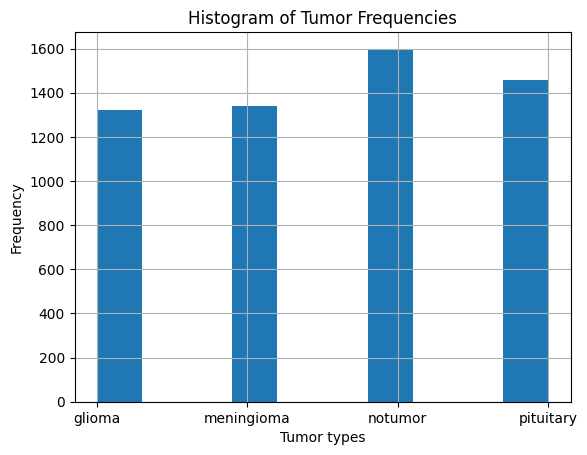

In [25]:
df['label'].hist()
# set plot labels
plt.xlabel('Tumor types')
plt.ylabel('Frequency')
plt.title('Histogram of Tumor Frequencies')

# show the plot
plt.show()

## Pre-Processing

Text(0.5, 1.0, 'Pre-Processed')

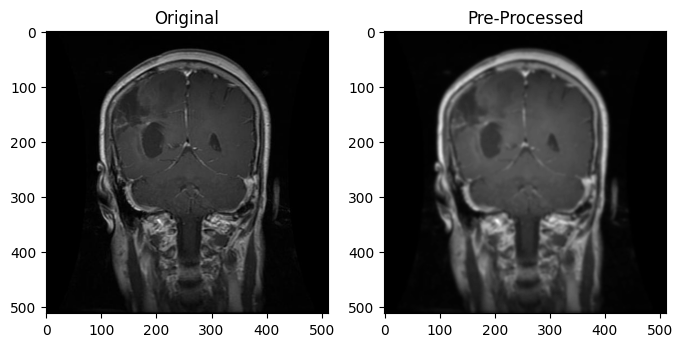

In [26]:
import matplotlib.image as mpimg

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
original = mpimg.imread("Training/glioma/Tr-gl_0010.jpg")
after_pre_processing=mpimg.imread("PreProcessedTraining/glioma/Tr-gl_0010.jpg")
# Show the images on the subplots
ax1.imshow(original)
ax2.imshow(after_pre_processing, cmap='gray')
# Add titles to the subplots
ax1.set_title('Original')
ax2.set_title('Pre-Processed')

## Feature Extraction

In [27]:
from skimage.feature.texture  import graycomatrix, graycoprops

contrast=[]
homogeneity=[]
energy=[]
correlation=[]
mean_intensity =[]
variance_intensity=[]
skewness_intensity=[]
kurtosis_intensity=[]

features = pd.DataFrame({
    'contrast': [],
    'homogeneity': [],
    'energy': [],
    'correlation': [],
    'mean_intensity' :[],
    'variance_intensity' :[],
    'skewness_intensity' :[],
    'kurtosis_intensity' :[]
})

for image in X:
    
    image = np.reshape(image, (256, 256))
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Compute some GLCM properties
    contrast.append(graycoprops(glcm, 'contrast')[0][0])
    homogeneity.append(graycoprops(glcm, 'homogeneity')[0][0])
    energy.append(graycoprops(glcm, 'energy')[0][0])
    correlation.append(graycoprops(glcm, 'correlation')[0][0])

    # Compute intensity features
    img_mean_intensity=np.mean(image)
    img_variance_intensity=np.var(image)
    mean_intensity.append(img_mean_intensity)
    variance_intensity.append(img_variance_intensity)
    skewness_intensity.append(np.mean((image - img_mean_intensity) ** 3) / (img_variance_intensity ** (3/2)))
    kurtosis_intensity.append(np.mean((image - img_mean_intensity) ** 4) / (img_variance_intensity ** 2))
    
   
features['contrast']=contrast
features['homogeneity']=homogeneity
features['energy']=energy
features['correlation']=correlation
features['mean_intensity']=mean_intensity
features['variance_intensity']=variance_intensity
features['skewness_intensity']=skewness_intensity
features['kurtosis_intensity']=kurtosis_intensity

C:\Users\Hager\AppData\Local\Temp\ipykernel_15548\1941772050.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(np.unique(Y)))


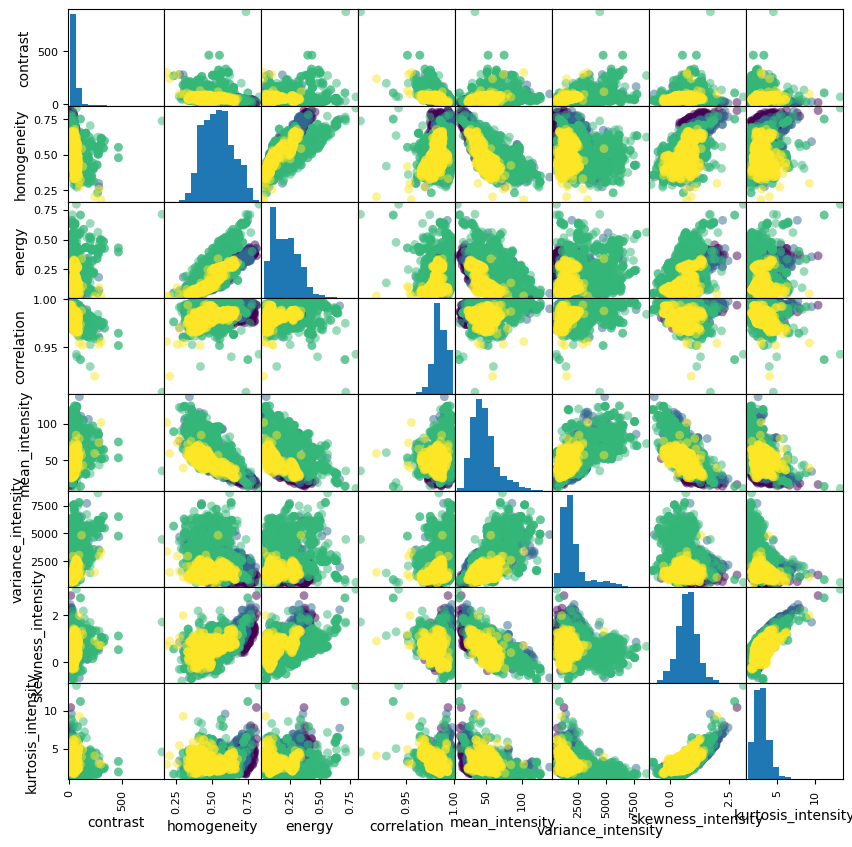

In [28]:
from matplotlib import cm
cmap = plt.cm.get_cmap('viridis', len(np.unique(Y)))
scatter = pd.plotting.scatter_matrix(features,c=Y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(10,10))


## Dimensionality Reduction

In [29]:
from sklearn.decomposition import PCA

def Pca_transform(X):
    # Define the number of components to extract
    num_components = 100

    # Initialize the PCA method
    pca = PCA(n_components=num_components)

    # Fit the PCA method to the data
    pca.fit(X)
    # Transform the data to its principal components
    X_pca = pca.transform(X)

    # Print the explained variance ratio for each component
    print(pca.explained_variance_ratio_)
    return X_pca

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_pca=Pca_transform(X)
X_train, x_val, y_train, y_val = train_test_split(X_pca,Y,test_size=0.2,random_state=42)


## Random Forest

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  r2_score
from sklearn.model_selection import GridSearchCV


In [ ]:

param_grid = {'n_estimators': [50, 100, 200]}
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rfc, param_grid, cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)
# Get the best value of k
best_n_estimators = grid_search.best_params_['n_estimators']


In [ ]:
print("Best n estimators:",best_n_estimators)

Best n estimators: 200


Accuracy 0.9081364829396326


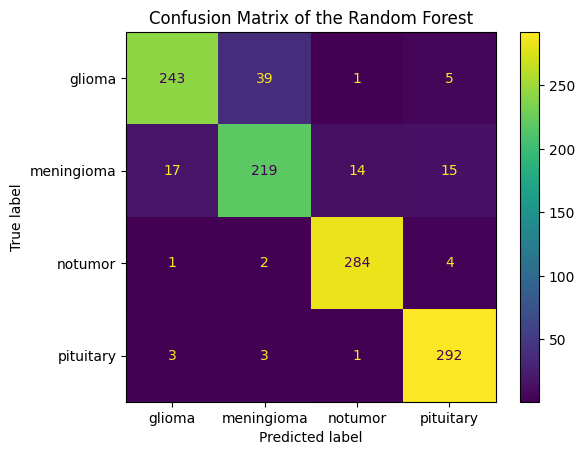

In [ ]:

# train with random forest 
RF = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
RF.fit(X_train,y_train)


y_pred_rf = RF.predict(x_val)

accuracy_rf = accuracy_score(y_val,y_pred_rf)
val_rf = r2_score(y_val,y_pred_rf)*100
print("Accuracy",accuracy_rf)

cm_rf = confusion_matrix(y_val, y_pred_rf)
recall_rf = cm_rf[0][0]/(cm_rf[0][0] +cm_rf[0][1])
precision_rf = cm_rf[0][0]/(cm_rf[0][0]+cm_rf[1][1])

from sklearn import metrics

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = ['glioma', 'meningioma', 'notumor', 'pituitary'])


cm_display.plot()
plt.title("Confusion Matrix of the Random Forest")
plt.show()


## KNN

In [ ]:

param_grid = {'n_neighbors': range(1, 21)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)
# Get the best value of k
best_k = grid_search.best_params_['n_neighbors']
print("Best K:",best_k)

Best K: 1


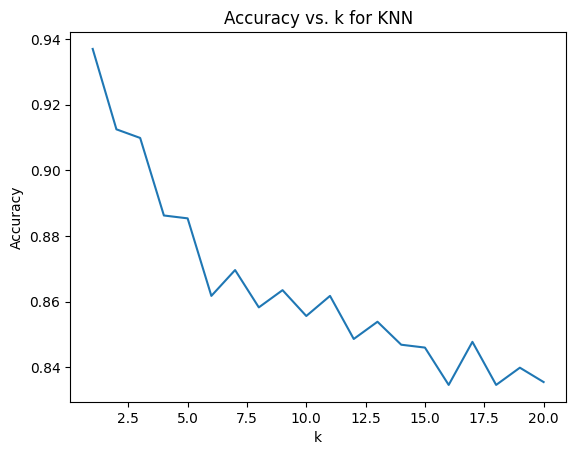

In [ ]:
k_values = range(1, 21)
accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = knn.score(x_val, y_val)
    accuracies.append(accuracy)

# Plot the accuracies for each k value
plt.plot(k_values, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for KNN')
plt.show()

In [ ]:
# train with knn model 
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train,y_train)

y_pred_knn = knn.predict(x_val)
accuracy_knn = accuracy_score(y_val, y_pred_knn)

val_knn = r2_score(y_val, y_pred_knn)*100
print("Accuracy of KNN model:", accuracy_knn)

cm_knn = confusion_matrix(y_val,y_pred_knn)



recall_knn = cm_knn[0][0]/(cm_knn[0][0] +cm_knn[0][1])
precision_knn= cm_knn[0][0]/(cm_knn[0][0]+cm_knn[1][1])

Accuracy of KNN model: 0.937007874015748


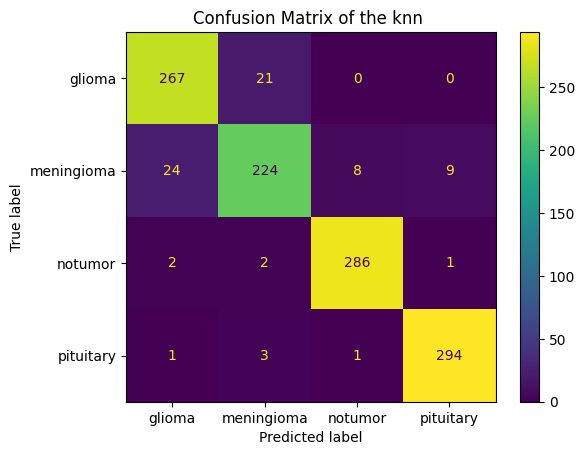

In [ ]:
from sklearn import metrics

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_knn, display_labels = ['glioma', 'meningioma', 'notumor', 'pituitary'])

cm_display.plot()
plt.title("Confusion Matrix of the knn ")
plt.show()

## SVM


In [ ]:
# train with swm model 
svm = SVC(kernel="linear",C=1)
svm.fit(X_train,y_train)

y_pred_svm = svm.predict(x_val)
accuracy_svm = accuracy_score(y_val, y_pred_svm)

val_svm = r2_score(y_val, y_pred_svm)*100

print("Accuracy of SVM model:", accuracy_svm)
cm_svm = confusion_matrix(y_val,y_pred_svm)
 


recall_svm = cm_svm[0][0]/(cm_svm[0][0] +cm_svm[0][1])
precision_svm= cm_svm[0][0]/(cm_svm[0][0]+cm_svm[1][1])


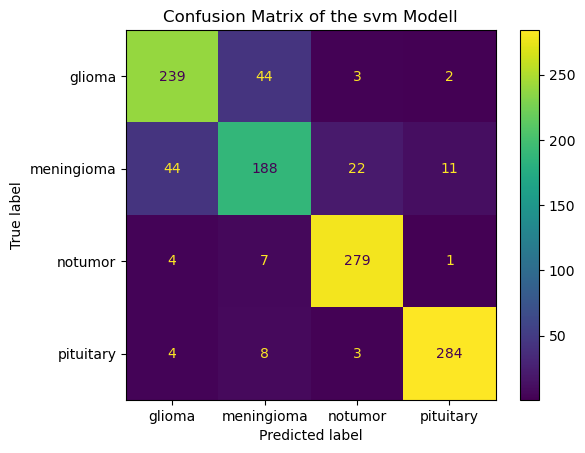

In [ ]:
from sklearn import metrics

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_svm, display_labels =['glioma', 'meningioma', 'notumor', 'pituitary'])

cm_display.plot()
plt.title("Confusion Matrix of the svm Modell")
plt.show()

## model Evaluation

In [ ]:
report = classification_report(y_val, y_pred_svm) # for svm model
print(report)

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       288
           1       0.76      0.71      0.73       265
           2       0.91      0.96      0.93       291
           3       0.95      0.95      0.95       299

    accuracy                           0.87      1143
   macro avg       0.86      0.86      0.86      1143
weighted avg       0.86      0.87      0.86      1143



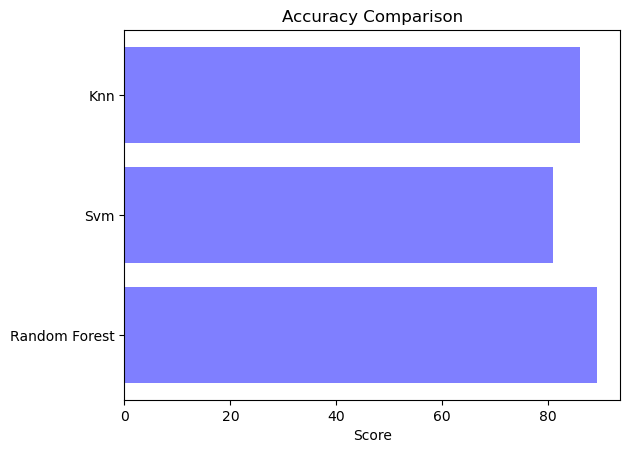

In [ ]:
import matplotlib.pyplot as plt2

score = [val_rf,val_svm,val_knn]
#make variabel for save the result and to show it
classifier = ('Random Forest','Svm','Knn')
y_pos = np.arange(len(classifier))
print(y_pos)
print(score)

plt2.barh(y_pos, score, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Score')
plt2.title('Accuracy Comparison')
plt2.show()

In [ ]:
results ={'Accuracy': [accuracy_rf*100,accuracy_svm*100,accuracy_knn*100],
 'Recall':[recall_rf*100,recall_svm*100,recall_knn*100],
 'Precision': [precision_rf*100,precision_svm*100,precision_knn*100]}
index = ['Random Forest','Svm','Knn']

In [ ]:
results =pd.DataFrame(results,index=index)

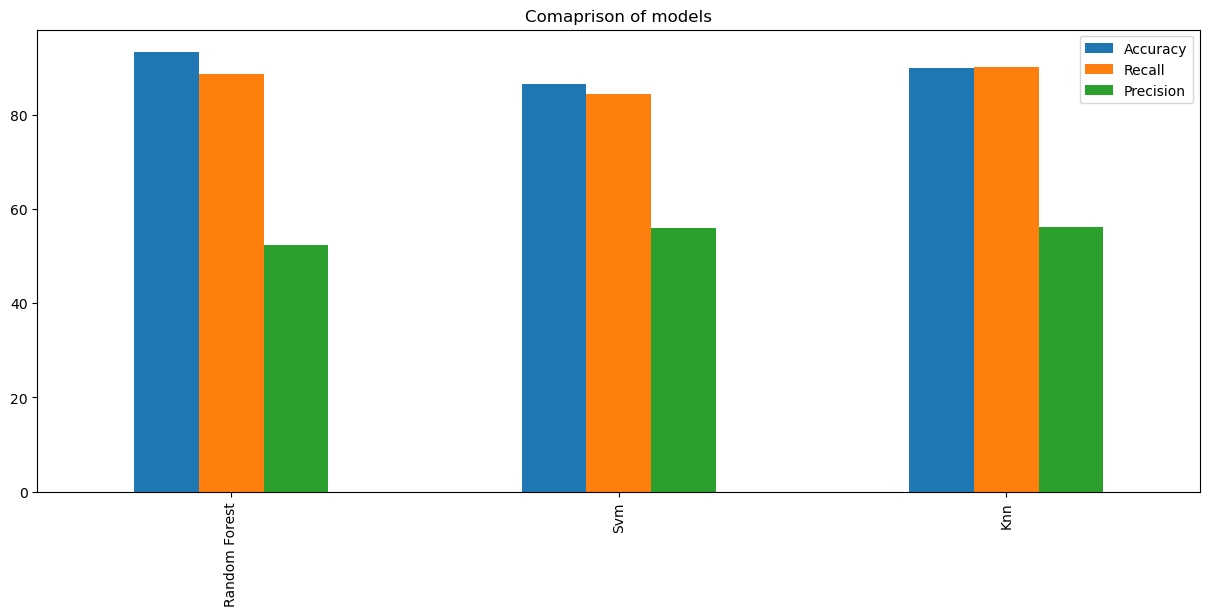

In [ ]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(15,6)).get_figure()
fig.savefig('acc.png')

## Visualization

In [ ]:
# corrmat = df.corr()
# plt.subplots(figsize=(18,18))
# sns.heatmap(corrmat,annot=True, square=True, vmin=0, vmax=1,cmap="YlGnBu")
# plt.savefig('Downloads\correlation_map.png')